# Daten einlesen und Pipeline definieren

In [18]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score


def r2(actual: np.ndarray, predicted: np.ndarray):
    """ R2 Score """
    return r2_score(actual, predicted)

def adjr2(actual: np.ndarray, predicted: np.ndarray, rowcount: int, featurecount: int):
    """ Adjusted R2 Score """
    return 1-(1-r2(actual,predicted))*(rowcount-1)/(rowcount-featurecount)

def add_features(df):
    df['Jahr'] = df['Datum'].dt.year
    df['Monat'] = df['Datum'].dt.month
    df['Wochentag'] = df['Datum'].dt.weekday
    df['Kalenderwoche'] = df['Datum'].dt.isocalendar().week
    df['Tag_im_Jahr'] = df['Datum'].dt.dayofyear
    df['Ist_Wochenende'] = df['Wochentag'].isin([5, 6]).astype(int)
    df['Tag_im_Jahr_sin'] = np.sin(2 * np.pi * df['Tag_im_Jahr'] / 365)
    df['Tag_im_Jahr_cos'] = np.cos(2 * np.pi * df['Tag_im_Jahr'] / 365)
    df['Monat_sin'] = np.sin(2 * np.pi * df['Monat'] / 12)
    df['Monat_cos'] = np.cos(2 * np.pi * df['Monat'] / 12)
    df['Wochentag_sin'] = np.sin(2 * np.pi * df['Wochentag'] / 7)
    df['Wochentag_cos'] = np.cos(2 * np.pi * df['Wochentag'] / 7)
    return df

def preprocess_data(df):
    df['Datum'] = pd.to_datetime(df['Datum'])
    df = add_features(df)
    df['KielerWoche'] = df['KielerWoche'].fillna(False).astype('int')
    df['Wettercode'] = df['Wettercode'].fillna('Unbekannt').astype(str)
    return df

# Load datasets

# Basisdatenset
df1 = pd.read_csv('../umsatzdaten_gekuerzt.csv')
# Wetterdaten
df2 = pd.read_csv('../wetter.csv')
# Kielerwocher
df3 = pd.read_csv('../kiwo.csv')
# Feiertage, Brückentage, Ferien
df4 = pd.read_csv('../Feier_Bruecke_Ferien_bis2018.csv')
# Verbraucherpreisindex
df5 = pd.read_csv('../VPI.csv')
# Erzeugerpreisindex
df6 = pd.read_csv('../EPI.csv')
# Heimspiele Holstein Kiel
df7 = pd.read_csv('../Heimspiel_Holstein_Kiel_finle.csv')
# Kieler Umschlag (kleineres Fest in Kiel)
df8 = pd.read_csv('../Kieler_Umschlag_finale.csv')
# Schulferien Litauen
df9 = pd.read_csv('../Schulferien_Litauen_finale.csv')

# Convert 'Datum' columns to datetime
df1['Datum'] = pd.to_datetime(df1['Datum'])
df2['Datum'] = pd.to_datetime(df2['Datum'])
df3['Datum'] = pd.to_datetime(df3['Datum'])
df4['Datum'] = pd.to_datetime(df4['Datum'])
df5['Datum'] = pd.to_datetime(df5['Datum'])
df6['Datum'] = pd.to_datetime(df6['Datum'])
df7['Datum'] = pd.to_datetime(df7['Datum'])
df8['Datum'] = pd.to_datetime(df8['Datum'])
df9['Datum'] = pd.to_datetime(df9['Datum'])

# Merge datasets
df = df1.merge(df2, on='Datum', how='left')
df = df.merge(df3, on='Datum', how='left')
df = df.merge(df4, on='Datum', how='left')
df = df.merge(df5, on='Datum', how='left')
df = df.merge(df6, on='Datum', how='left')
df = df.merge(df7, on='Datum', how='left')
df = df.merge(df8, on='Datum', how='left')
df = df.merge(df9, on='Datum', how='left')




# Preprocess data
df = preprocess_data(df)

# Check for missing values after preprocessing
# missing_values = df.isnull().sum()
# print(missing_values)

# Define feature groups
numeric_features = ['Temperatur', 'Bewoelkung','HeimspielHK', 'KielerUmschlag', 'Windgeschwindigkeit', 'Tag_im_Jahr_sin', 'Tag_im_Jahr_cos', 'Monat_sin', 'Monat_cos', 'Wochentag_sin', 'Wochentag_cos', 'feiertag', 'KielerWoche', 'brueckentag', 'BW', 'BY', 'B', 'BB', 'HB', 'HH', 'HE', 'MV', 'NI', 'NW', 'RP', 'SL', 'SN', 'ST', 'SH', 'TH', 'VPI_brot_getreide', 'VPI_molkerei_ei', 'VPI_speiseoel_fett', 'VPI_Obst', 'VPI_zucker_suesses', 'EPI_teig', 'EPI_wasser', 'EPI_strom', 'EPI_fernwaerme', 'Herbstferien_LI', 'Weihnachtsferien_LI', 'Winterferien_LI', 'Fruehlingsferien_LI', 'Sommerferien_LI']
categorical_features = ['Warengruppe', 'Wettercode', 'Wochentag']

# Define ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        # Numerical features: Impute missing values with mean and scale the features
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numeric_features),
        # Wettercode feature: One-hot encode the categorical feature
        ('wettercode', OneHotEncoder(handle_unknown='ignore'), ['Wettercode']),
        # Warengruppe feature: One-hot encode the categorical feature
        ('warengruppe', OneHotEncoder(handle_unknown='ignore'), ['Warengruppe']),
        # Wochentag feature: One-hot encode the categorical feature
        ('wochentag', OneHotEncoder(handle_unknown='ignore'), ['Wochentag'])
    ],
    remainder='drop'
)


# Split data
train_end_date = '2016-12-31'
validation_end_date = '2017-12-31'
train_data = df[df['Datum'] <= train_end_date]
validation_data = df[(df['Datum'] > train_end_date) & (df['Datum'] <= validation_end_date)]
#train_data = pd.concat([train_data, validation_data])
test_data = df[df['Datum'] > validation_end_date]

# Convert datetime columns to numerical values
X_train = train_data.drop(['Umsatz'], axis=1)
y_train = train_data['Umsatz']
X_train['Datum'] = X_train['Datum'].astype(int) / 10**9
X_test = test_data.drop(['Umsatz'], axis=1)
y_test = test_data['Umsatz']
X_val = validation_data.drop(['Umsatz'], axis=1)
X_val['Datum'] = X_val['Datum'].astype(int) / 10**9
y_val = validation_data['Umsatz']

X = df.drop(['Umsatz'], axis=1)
y = df['Umsatz']



# Transformation der Daten
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)
X_val_preprocessed = preprocessor.transform(X_val)

# Überprüfen der Dimensionen der transformierten Daten
input_shape = X_train_preprocessed.shape[1]




# 1. Neuronales Netz trainieren

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam



model1 = Sequential([
  InputLayer(shape=(input_shape, )),
  BatchNormalization(),
  Dense(72, activation='relu'),
  Dropout(0.2),  # Regularisierung
  Dense(36, activation='relu'),
  Dropout(0.2),  # Regularisierung
  Dense(18, activation='relu'),
  Dense(1, activation='linear')
])

model1.summary()

model1.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Training
history1 = model1.fit(
    X_train_preprocessed,
    y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=50,
    batch_size=36,
    verbose=1
)

y_pred = model1.predict(X_test_preprocessed)
print("R² for model1 on test:", r2_score(y_test, y_pred))
print("adjusted R² for model1 on test:", adjr2(y_test, y_pred, len(y), X.shape[1]))


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_8           │ (None, 77)             │           308 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 72)             │         5,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 72)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 36)             │         2,628 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 36)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 18)             │           666 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            19 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,237 (36.08 KB)

 Trainable params: 9,083 (35.48 KB)

 Non-trainable params: 154 (616.00 B)

Epoch 1/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 61042.1680 - mae: 200.3263 - val_loss: 12627.1582 - val_mae: 78.0660
Epoch 2/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 9991.7285 - mae: 68.7411 - val_loss: 4196.4722 - val_mae: 44.1234
Epoch 3/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - loss: 7251.8691 - mae: 53.9007 - val_loss: 3402.2703 - val_mae: 39.7283
Epoch 4/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 6568.3584 - mae: 52.6115 - val_loss: 3153.5068 - val_mae: 37.4078
Epoch 5/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 758us/step - loss: 6440.6729 - mae: 49.6079 - val_loss: 2941.6692 - val_mae: 35.7243
Epoch 6/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - loss: 6373.9805 - mae: 48.7034 - val_loss: 2792.4648 - val_mae: 34.9086
Epoch 7/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step - loss: 6443.8296 - mae: 48.0837 - val_loss: 2579.0947 - val_mae: 32.9934
Epoch 8/50
180/180 ━━━━━━━━━━━━━━━━━━━━ 0s 767us/step - loss: 6266.6855 - mae: 47.7665 - val_loss: 2770

# RNN (not working)

In [ ]:
# from tensorflow.keras.layers import LSTM 

# # Reshape the data to include timesteps
# timesteps = 1  # Assuming each row is a single timestep

# # Define the input shape for the RNN
# input_shape2 = (timesteps, X_train_preprocessed.shape[1])

# # Define the RNN model
# rnn_model = Sequential([
#   InputLayer(shape=input_shape2),
#   BatchNormalization(),
#   LSTM(64, activation='relu', return_sequences=True),
#   Dropout(0.2),
#   LSTM(32, activation='relu'),
#   Dropout(0.2),
#   Dense(1, activation='linear')
# ])

# rnn_model.summary()

# rnn_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# # Training the RNN model
# rnn_history = rnn_model.fit(
#   X_train_preprocessed,
#   y_train,
#   validation_data=(X_test_preprocessed, y_test),
#   epochs=50,
#   batch_size=32,
#   verbose=1
# )

# rnn_y_pred = rnn_model.predict(X_test_preprocessed)
# print("R² on test (RNN):", r2_score(y_test, rnn_y_pred))
# print("adjusted R² on test (RNN):", adjr2(y_test, rnn_y_pred, len(y), X.shape[1]))

# MAPE

# Hyperparameter Optimisation mit Optuna

In [8]:
# v1 only check batch size

import optuna
import tensorflow as tf

# Convert datetime columns to numerical values
X_train_preprocessed = X_train_preprocessed.astype(float)
X_test_preprocessed = X_test_preprocessed.astype(float)

def objective(trial):
    history = model.fit(X_train_preprocessed, y_train, validation_data=(X_val_preprocessed, y_val), 
                        epochs=10, batch_size=trial.suggest_int('batch_size', 16, 128), verbose=0)
    val_loss = min(history.history['val_loss'])
    return val_loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("Beste Parameter:", study.best_params)
print("Bestes Ergebnis (val_mae):", study.best_value)


[I 2025-01-08 14:01:31,302] A new study created in memory with name: no-name-59536744-b497-4dd2-b1f6-3e80dfc02bcf
[I 2025-01-08 14:01:32,357] Trial 0 finished with value: 1553.1724853515625 and parameters: {'batch_size': 67}. Best is trial 0 with value: 1553.1724853515625.
[I 2025-01-08 14:01:34,299] Trial 1 finished with value: 1695.6005859375 and parameters: {'batch_size': 28}. Best is trial 0 with value: 1553.1724853515625.
[I 2025-01-08 14:01:35,733] Trial 2 finished with value: 1583.454345703125 and parameters: {'batch_size': 46}. Best is trial 0 with value: 1553.1724853515625.
[I 2025-01-08 14:01:37,073] Trial 3 finished with value: 1503.6038818359375 and parameters: {'batch_size': 91}. Best is trial 3 with value: 1503.6038818359375.
[I 2025-01-08 14:01:38,427] Trial 4 finished with value: 1518.80322265625 and parameters: {'batch_size': 73}. Best is trial 3 with value: 1503.6038818359375.
[I 2025-01-08 14:01:39,273] Trial 5 finished with value: 1578.1971435546875 and parameters: 

Beste Parameter: {'batch_size': 36}
Bestes Ergebnis (val_mae): 1219.6011962890625


In [10]:
# v2 create a study for units, activation functions, and dropout rates
import optuna
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification




def create_model(trial):
    model = Sequential()
    n_layers = trial.suggest_int("n_layers", 1, 5)
    for i in range(n_layers):
        units = trial.suggest_int(f"units_l{i}", 32, 128)
        activation = trial.suggest_categorical(f"activation_l{i}", ["relu", "tanh"])
        model.add(Dense(units=units, activation=activation))
        dropout_rate = trial.suggest_float(f"dropout_l{i}", 0.0, 0.3)
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="linear"))  # Output layer for regression
    optimizer = trial.suggest_categorical("optimizer", ["adam", "sgd"])
    lr = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    if optimizer == "adam":
        optimizer = Adam(learning_rate=lr)
    elif optimizer == "sgd":
        optimizer = SGD(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])  # Use MSE for regression
    return model

def objective(trial):
    model = create_model(trial)
    history = model.fit(X_train_preprocessed, y_train, validation_data=(X_val_preprocessed, y_val), batch_size=36, epochs=10, verbose=0)
    val_loss = min(history.history["val_loss"])  # Minimize validation loss
    return val_loss

study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=50)

print("Best parameters:", study.best_params)

[I 2025-01-08 14:04:12,392] A new study created in memory with name: no-name-131022a4-480a-4d99-9755-9ebba636263e
/var/folders/tv/qpxdljv13vd6jxppkbwll56w0000gn/T/ipykernel_72420/3931713560.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[W 2025-01-08 14:04:14,057] Trial 0 failed with parameters: {'n_layers': 1, 'units_l0': 98, 'activation_l0': 'relu', 'dropout_l0': 0.22577032048235113, 'optimizer': 'sgd', 'learning_rate': 0.005574994192707198} because of the following error: The value nan is not acceptable.
[W 2025-01-08 14:04:14,058] Trial 0 failed with value nan.
/var/folders/tv/qpxdljv13vd6jxppkbwll56w0000gn/T/ipykernel_72420/3931713560.py:22: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

Best parameters: {'n_layers': 3, 'units_l0': 49, 'activation_l0': 'relu', 'dropout_l0': 0.047363439609676296, 'units_l1': 91, 'activation_l1': 'tanh', 'dropout_l1': 0.21764320848093135, 'units_l2': 85, 'activation_l2': 'relu', 'dropout_l2': 0.22263911123621294, 'optimizer': 'adam', 'learning_rate': 0.001426698005939382}


# Optimiertes Modell

In [20]:
# Optimiertes model v2
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam

# Create the Sequential model
model2 = Sequential()
model2.add(InputLayer(shape=(input_shape, )),
  BatchNormalization(),)
model2.add(Dense(units=111, activation='relu'))
model2.add(Dropout(0.08203343086809235))
#Best parameters: {'n_layers': 1, 'units_l0': 111, 'activation_l0': 'relu', 'dropout_l0': 0.08203343086809235, 
# 'optimizer': 'adam', 'learning_rate': 0.00707049936840233}





# Output Layer
# Replace `output_units` and `output_activation` based on your task (e.g., binary classification, regression, etc.)
model2.add(Dense(units=1, activation='linear'))

# Optimizer
optimizer = Adam(learning_rate=0.00707049936840233)

# Compile the model
#model2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])  # Modify loss/metrics as needed
model2.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history2 = model2.fit(
    X_train_preprocessed, y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=50, batch_size=112, verbose=1
)

# Predict using model2
y_pred2 = model2.predict(X_test_preprocessed).flatten()

# Calculate R² and adjusted R² for model2
r2_model2 = r2_score(y_test, y_pred2)
adjr2_model2 = adjr2(y_test, y_pred2, len(y), X_test_preprocessed.shape[1])

print("R² for model2 on test:", r2_model2)
print("Adjusted R² for model2 on test:", adjr2_model2)



Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61468.8555 - mae: 196.8373 - val_loss: 21743.6641 - val_mae: 104.2606
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23659.8555 - mae: 112.0577 - val_loss: 12593.2402 - val_mae: 81.8991
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18369.3223 - mae: 96.4977 - val_loss: 9223.9873 - val_mae: 67.5520
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11327.9600 - mae: 76.1898 - val_loss: 5617.2559 - val_mae: 50.6201
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7246.2725 - mae: 55.4477 - val_loss: 3910.9404 - val_mae: 42.6975
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6722.0200 - mae: 47.9273 - val_loss: 3270.3052 - val_mae: 39.0602
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4674.8418 - mae: 43.1385 - val_loss: 3746.5356 - val_mae: 43.0496
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5221.4277 - mae: 42.7239 - val_loss: 3088.0574 - val_mae: 38.1525

In [21]:
# Optimiertes model v3
from keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Dropout, BatchNormalization
from keras.optimizers import SGD, Adam

# Create the Sequential model
model3 = Sequential()



model3.add(InputLayer(shape=(input_shape, )),
  BatchNormalization(),)


model3.add(Dense(units=49, activation='relu'))
model3.add(Dropout(0.047363439609676296))

model3.add(Dense(units=91, activation='tanh'))
model3.add(Dropout(0.21764320848093135))

model3.add(Dense(units=85, activation='relu'))
model3.add(Dropout(0.22263911123621294))


# Output Layer
# Replace `output_units` and `output_activation` based on your task (e.g., binary classification, regression, etc.)
model3.add(Dense(units=1, activation='linear'))

# Optimizer
optimizer = Adam(learning_rate=0.001426698005939382)

# Compile the model
model3.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

history3 = model3.fit(
    X_train_preprocessed, y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=50, batch_size=112, verbose=1
)

# Predict using model3
y_pred2 = model3.predict(X_test_preprocessed).flatten()

# Calculate R² and adjusted R² for model3
r2_model3 = r2_score(y_test, y_pred2)
adjr2_model3 = adjr2(y_test, y_pred2, len(y), X_test_preprocessed.shape[1])

print("R² for model3 on test:", r2_model3)
print("Adjusted R² for model3 on test:", adjr2_model3)



Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 66547.5547 - mae: 205.3891 - val_loss: 28893.1270 - val_mae: 118.6260
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32095.7363 - mae: 121.8597 - val_loss: 15889.6025 - val_mae: 100.2035
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23600.3750 - mae: 114.7803 - val_loss: 14098.7109 - val_mae: 92.1862
Epoch 4/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20213.3691 - mae: 103.6887 - val_loss: 10783.9121 - val_mae: 78.8456
Epoch 5/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13069.4980 - mae: 72.3654 - val_loss: 10334.5488 - val_mae: 82.9764
Epoch 6/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6584.7607 - mae: 51.9154 - val_loss: 9669.5098 - val_mae: 80.1198
Epoch 7/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5662.1914 - mae: 48.6419 - val_loss: 7496.9629 - val_mae: 69.5413
Epoch 8/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4521.2524 - mae: 44.4806 - val_loss: 7641.3062 - val_mae: 

# Loss functions

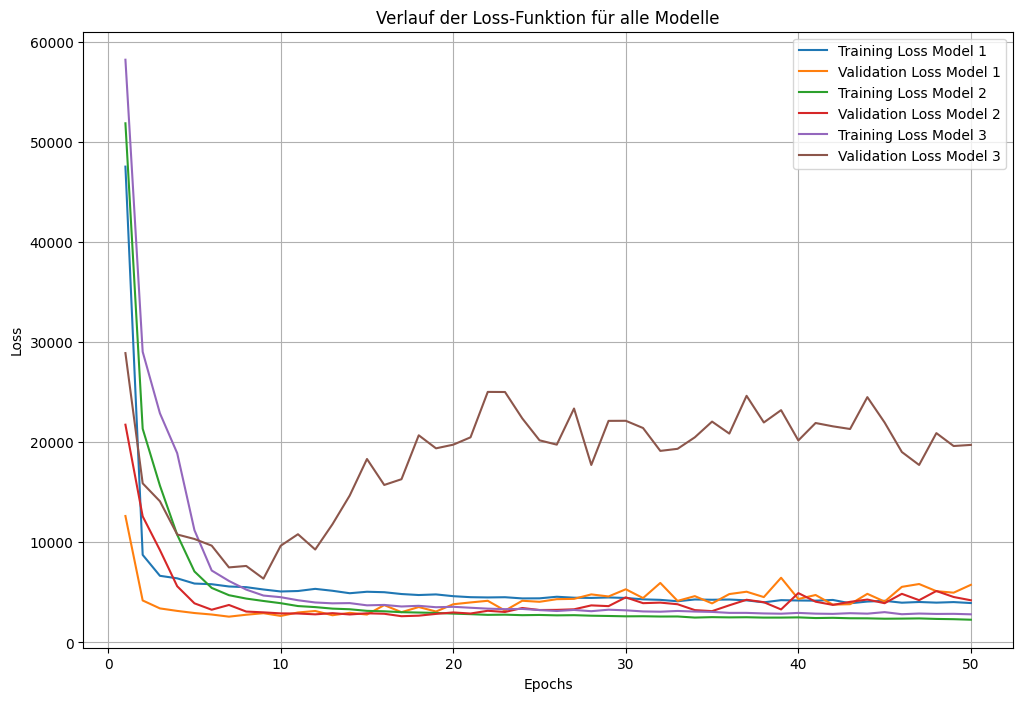

In [22]:
import matplotlib.pyplot as plt

# Verlaufsdaten extrahieren
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
epochs = range(1, len(train_loss) + 1)


# Verlaufsdaten für history1, history2 und history3 extrahieren
train_loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
train_loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
train_loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

# Diagramm erstellen
plt.figure(figsize=(12, 8))
plt.plot(epochs, train_loss1, label='Training Loss Model 1')
plt.plot(epochs, val_loss1, label='Validation Loss Model 1')
plt.plot(epochs, train_loss2, label='Training Loss Model 2')
plt.plot(epochs, val_loss2, label='Validation Loss Model 2')
plt.plot(epochs, train_loss3, label='Training Loss Model 3')
plt.plot(epochs, val_loss3, label='Validation Loss Model 3')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Verlauf der Loss-Funktion für alle Modelle')
plt.legend()
plt.grid(True)
plt.show()

# MAPE

In [24]:


def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE)
    
    Parameters:
    y_true (array-like): Actual values
    y_pred (array-like): Predicted values
    
    Returns:
    float: MAPE value
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Ensure y_pred has the same number of elements as y_test
y_pred1 = model1.predict(X_test_preprocessed).flatten()
y_pred2 = model2.predict(X_test_preprocessed).flatten()
y_pred3 = model2.predict(X_test_preprocessed).flatten()

mape1 = mean_absolute_percentage_error(y_test, y_pred1)
mape2 = mean_absolute_percentage_error(y_test, y_pred2)
mape3 = mean_absolute_percentage_error(y_test, y_pred3)
print (mape1, mape2, mape3)

# Calculate MAPE for each Warengruppe
for wg in range(1, 6):
    wg_mask = test_data['Warengruppe'] == wg
    wg_y_test = y_test[wg_mask]
    wg_y_pred1 = y_pred1[wg_mask]
    wg_y_pred2 = y_pred2[wg_mask]
    wg_y_pred3 = y_pred3[wg_mask]
    
    wg_mape1 = mean_absolute_percentage_error(wg_y_test, wg_y_pred1)
    wg_mape2 = mean_absolute_percentage_error(wg_y_test, wg_y_pred2)
    wg_mape3 = mean_absolute_percentage_error(wg_y_test, wg_y_pred3)
    
    print(f"Warengruppe {wg} - MAPE Model 1: {wg_mape1:.2f}%")
    print(f"Warengruppe {wg} - MAPE Model 2: {wg_mape2:.2f}%")
    print(f"Warengruppe {wg} - MAPE Model 3: {wg_mape3:.2f}%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 578us/step
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 520us/step
44.50183505468389 42.920666662687964 42.920666662687964
Warengruppe 1 - MAPE Model 1: 41.95%
Warengruppe 1 - MAPE Model 2: 56.38%
Warengruppe 1 - MAPE Model 3: 56.38%
Warengruppe 2 - MAPE Model 1: 36.40%
Warengruppe 2 - MAPE Model 2: 22.52%
Warengruppe 2 - MAPE Model 3: 22.52%
Warengruppe 3 - MAPE Model 1: 39.26%
Warengruppe 3 - MAPE Model 2: 28.74%
Warengruppe 3 - MAPE Model 3: 28.74%
Warengruppe 4 - MAPE Model 1: 76.00%
Warengruppe 4 - MAPE Model 2: 76.61%
Warengruppe 4 - MAPE Model 3: 76.61%
Warengruppe 5 - MAPE Model 1: 28.90%
Warengruppe 5 - MAPE Model 2: 30.36%
Warengruppe 5 - MAPE Model 3: 30.36%


# Modell auf Submission-Datensatz laufen lassen

In [6]:
# Prepare submission
df_sub = pd.read_csv('../sample_submission.csv')
df_sub['id'] = df_sub['id'].astype('string')
df_sub['Tag'] = df_sub['id'].str[0:2]
df_sub['Monat'] = df_sub['id'].str[2:4]
df_sub['Jahr'] = '20' + df_sub['id'].str[4:6]
df_sub['Warengruppe'] = df_sub['id'].str[6].astype(int)
df_sub.rename(columns={'Jahr':'year', 'Monat':'month', 'Tag':'day'}, inplace=True)
df_sub['Datum'] = pd.to_datetime(df_sub[['year','month','day']])

# Convert 'Datum' column in all DataFrames to datetime64[ns]
df_sub['Datum'] = pd.to_datetime(df_sub['Datum'])
df2['Datum'] = pd.to_datetime(df2['Datum'])
df3['Datum'] = pd.to_datetime(df3['Datum'])
df4['Datum'] = pd.to_datetime(df4['Datum'])
df5['Datum'] = pd.to_datetime(df5['Datum'])
df6['Datum'] = pd.to_datetime(df6['Datum'])
df7['Datum'] = pd.to_datetime(df7['Datum'])
df8['Datum'] = pd.to_datetime(df8['Datum'])
df9['Datum'] = pd.to_datetime(df9['Datum'])

# Merge with other datasets
df_sub = df_sub.merge(df2, on='Datum', how='left')
df_sub = df_sub.merge(df3, on='Datum', how='left')
df_sub = df_sub.merge(df4, on='Datum', how='left')
df_sub = df_sub.merge(df5, on='Datum', how='left')
df_sub = df_sub.merge(df6, on='Datum', how='left')
df_sub = df_sub.merge(df7, on='Datum', how='left')
df_sub = df_sub.merge(df8, on='Datum', how='left')
df_sub = df_sub.merge(df9, on='Datum', how='left')


# Preprocess submission data
df_sub = preprocess_data(df_sub)


# Preprocess submission data
df_sub_preprocessed = preprocessor.transform(df_sub)

# Predict and save submission
y_pred_sub = model3.predict(df_sub_preprocessed)
df_sub['Umsatz'] = y_pred_sub
df_sub[['id','Umsatz']].to_csv('../team9_model_submission.csv', index=False)

58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
